# EE 447 Final Project   

Name: Bert Zhao, Kelly Ho

Spring 2020 (rev 1.0)


 **Due June 12th at 11:59pm**


In [ ]:
!pip install control

import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.signal as signal
import control as ctrl
from sympy import *
from control import *
from matplotlib import animation
%matplotlib inline
plt.style.use('dark_background')

try: 
  import google.colab #test for colab
  import IPython
  def setup_typeset():
    """MathJax initialization for the current cell.
    
    This installs and configures MathJax for the current output.
    """
    IPython.display.display(IPython.display.HTML('''
        <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
        <script>
          (() => {
            const mathjax = window.MathJax;
            mathjax.Hub.Config({
            'tex2jax': {
              'inlineMath': [['$', '$'], ['\\(', '\\)']],
              'displayMath': [['$$', '$$'], ['\\[', '\\]']],
              'processEscapes': true,
              'processEnvironments': true,
              'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
              'displayAlign': 'center',
            },
            'HTML-CSS': {
              'styles': {'.MathJax_Display': {'margin': 0}},
              'linebreaks': {'automatic': true},
              // Disable to prevent OTF font loading, which aren't part of our
              // distribution.
              'imageFont': null,
            },
            'messageStyle': 'none'
          });
          mathjax.Hub.Configured();
        })();
        </script>
        '''))
  def custom_latex_printer(exp,**options):
      setup_typeset()
      return printing.latex(exp,**options)
  init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)
except:
  init_printing(use_latex='mathjax')

def find_Ts (y, t, G):
  Ts = 0
  avg = np.mean(y[int(round(len(y)*3/4)):len(y)]/G)
  for i in range(len(y)):
    check = abs(y[i]/G - avg) 
    if check > (avg*0.02):
      Ts = t[i]
      #print(t[i])
      #print(check)
  return Ts

def find_OS(y):
  avg = np.mean(y[int(round(len(y)*3/4)):len(y)])
  peak = max(y)
  return (peak-avg) / avg

def find_avg(y):
  return np.mean(y[int(round(len(y)*3/4)):len(y)])

# Overview

For this project, you will design several control systems for an electric self-ballancing scooter. You will use root
locus, full state feedback. To validate the approach, you will
simulate the complete system with the nonlinear model. You will also determine how well your controller works in
a discretized setting. Finally, you will assess the performance and
robustness to disturbances and noise in your system.

You should turn your project in as an executable Python notebook that runs
in Google colab and a PDF similar with the following formatting rules:

1. Your notebook should have a title, your name, the name of the course, and the date prominently displayed at the top.
1. Each below should be contained in a new section, with a large markdown heading of the form
```
# Task n: Title
```
followed by a short paragraph restating the goal of the task. 
1. Each task should include a *textual* description, including equations, of how you accomplished the task.  Please write in proper English will full sentences and paragraphs.  The standard here is higher than the homework and should **not** be in a question/answer format.
1. All code blocks should be included detailed comments. Extraneous cells that you used
for testing or side calculations should be deleted. 
1. Use figures wherever you can. You must
    - Label your axes.
    - Title your plots.
    - Label individual curves with legends when there are more than one curve per plot.
    - Overlay plots to make comparisons where applicable.
    - Use subplots to arrange related plots into a grid.
    - Adjust axes limits where appropriate to show the correct detail.
1. Over all your submission should read like a report with embedded code and a bit more structure as defined above.  The key thing to strive for is clarity!  And always explain what and why even if the task doesn't explicitly ask for it. 

## Grading

The project will be graded as a whole.  However, it will be split into two assignments.  The first assignment will be part A and will be due first.  The second assignment will be part A+B and will be due during finals week.  

The quality of A should be that of a final product and basic revisions will not be looked at when A+B is turned in.  The only exception is for major mistakes, which you will have to make obvious at first glance.  If there is enough time to complete the grading, fixes for major mistakes will be considered and applied to the final grading of the project.  Simply put, try and get part A right the first time as there is no guarantee revisions can be considered.  

The project will be graded as a whole but part A will be worth roughly XXX points.  That is, if you turned in a perfect part A and no part B you could expect XXX points.  

## optional components:

Optional portions of the project are worth additional points at the instruction team's discretion.  


# The System

Suppose you're building a self-balancing  scooter.  A model for such a scooter is defined by the following equations:

\begin{align}
(M+m)\ddot p - m\ell\cos(\theta)\ddot\theta +c\dot p+m\ell\dot\theta^2\sin(\theta)&=\tau R \\
-m\ell \cos(\theta)\ddot p + (J+m\ell^2)\ddot\theta+\gamma\dot\theta-mg\ell\sin(\theta)&= 0
\end{align}
Where $p$ is the position of the scooter; $\theta$ is the angle of the rider (with upright being $\theta=0$);$M$ is the mass of the scooter; $m$ , $J$ , and $\ell$ the rider's mass, moment-of-inertia, and leg length (~half of rider height); $c$ and $\gamma$ are coefficients of friction, $R$ is the radius of the wheels, and $g$ is the acceleration due to gravity. 

The scooter has the following parameters:

|variable|value|
|:------:|-----|
|$M$ | 40 kg   |
|$R$ | 0.25 m  |
|$g$ | 9.81 m/s$^2$ |
|$c$ | 0.7 |
|$\gamma$ | 0.2 | 

The following are the average rider's (a child) parameters:

|variable|value|
|:------:|-----|
|$m$   | 30 kg |
|$\ell$ | 0.75 m |
|$J$ | $\ell^2m$|


The scooter has the following features:

- It is controlled by a lever control that reports the desired velocity in m/s
- It is fitted with a speedometer that reports in m/s
- An off-the-shelf motor controller that controls the motor torque ($\tau$) in newton meters.

# PART A

##Task 1: Description 

Describe the system.  Explain what the inputs and outputs and states are and include an illustration showing the states:
\begin{align}
x_1 &= \dot p\\
x_2 &= \theta\\
x_3 &= \dot \theta.
\end{align}
Also include a block diagram of the system.


The system is like a Segway scooter. The user inputs the desired velocity to the motor controller using the lever input. There are three states of the system. The first is $x_1 = \dot p$ which is the linear velocity of the scooter. The second is $x_2 = \theta$ which is the angle from the vertical of the rider on the scooter. The third is $x_3 = \dot \theta$ which is the angular velocity of the angle from the vertical of the rider. The output of the system is the desired velocity which is state $x_1$.

The free body below illustrates the scooter based on the parameters from the net force and rotational inertia equations. All three states along with the input and output are illustrated.

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vTgATJTZEla7A26nwxtMZmzaf9Zkdr3bA7Tm_37SlslV6qZiVodQBYa1_1qk4_zy6Nd8l0jpD9KQjoZ/pub?w=960&h=720)

The block diagrams of the system are shown below. We can see that the user inputs the desired velocity via the lever input. Internal to the system, the controller outputs the torque to the plant. The controller also receives feedback from all three states. $\theta$ and $\dot \theta$ are internal conditions that are not decided by the user, but still important states for the controller to track in order to determine the proper torque output.

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vST2YPnSrJEjbmKxq6D4p1axQakblX6pqiy22Zi9MP-Kez-dx7rBzp8fwn2sBNyezguZbPZrwXFD-PE/pub?w=1056&h=816)

![alt text](https://docs.google.com/drawings/d/e/2PACX-1vRYTFnAs5yVNAMyymivXrzv1scjhCciIBasn8V8XV-YMqE45hA7n6wPl8V5RBTTCMiP97KeZsQezCXJ/pub?w=1056&h=816)


## Task 2: Performance Specification

People in vehicles generally do not like excessive acceleration (or [jerk](https://en.wikipedia.org/wiki/Jerk), but we'll ignore jerk for this project).  Suppose the maximum comfortable acceleration  is 2 m/s$^2$ and the maximum designed speed is 10 m/s.  People also do not like their velocity to oscillate.

Translate the above into a performance specification.  Include at least a specification for rise time of the output $y$ and a specification for overshoot.  


Performance Specification:
---

*   We model the Segway scooter as a critically damped system since we do not want the scooter's velocity to oscillate.

*   The maximum speed of the scooter is designed to be 8 m/s, so the scooter's velocity will not exceed 10 m/s.

*   The maximum and minimum accelerations of the scooter are designed to be 2 m/s$^2$ and 0.5 m/s$^2$ respectively.

*   The minimum rise time to achieve the maximum speed of 8 m/s is 4 seconds with a maximum acceleration of 2 m/s$^2$.

*   The maximum rise time to achieve the maximum speed of 8 m/s is 16 seconds with a minimum acceleration of 0.5 m/s$^2$.

*   As the scooter is designed as a critically damped system and its velocity does not oscillate, we would like to have the percent overshoot to be close to 0%.

## Task 3: Linearization & Analysis

To control this system using the methods in this course, you need to
obtain a linear model around the desired equilibrium point.

Begin by rewriting the model as a first order ODE in the from
$$\begin{pmatrix}
\dot x_1 \\
\dot x_2 \\
\dot x_3
\end{pmatrix} = \begin{pmatrix}
f_1(x_1,x_2,x_3,\tau) \\
f_2(x_1,x_2,x_3,\tau) \\
f_3(x_1,x_2,x_3,\tau)
\end{pmatrix}
$$


Pick an equilbrium point $(x_1^*,x_2^*,x_3^*,\tau^*)$ and justify your choice of equilibrium based on the physical system's use. 
Linearize the model of your system around this point to obtain a model of the form

\begin{eqnarray*}
\dot { x}  & = & A { x}  + B u \\
y  & = & C { x} 
\end{eqnarray*}

Determine the poles of the
system and discuss its natural (uncontrolled) behavior. Finally,
obtain a transfer function of the system. 

Note: If performing the linearization without the aid of computer algebra you may assume the rider is close to upright at all times (which is quite reasonable) and replace the sin and cos with it's [small angle approximation](https://en.wikipedia.org/wiki/Small-angle_approximation).  This effectively  does part of the linearization beforehand and does not change the result but will make manual computation easier. 

## Linearizing functions

In linearizing our model, we must first define $f_1$, $f_2$, and $f_3$. We know that the first order ODE of our system can be modeled as follows:

$$\begin{pmatrix}
\dot x_1 \\
\dot x_2 \\
\dot x_3
\end{pmatrix} = \begin{pmatrix}
f_1(x_1,x_2,x_3,\tau) \\
f_2(x_1,x_2,x_3,\tau) \\
f_3(x_1,x_2,x_3,\tau)
\end{pmatrix} = \begin{pmatrix}
\ddot p \\
\dot \theta \\
\ddot \theta
\end{pmatrix}
$$

We then solve for $\ddot p$, $\dot \theta$, and $\ddot \theta$ using the given equations modeling the scooter.

## Solving for $\ddot p$

First we rearrange both equations in terms of $\ddot \theta$. This gives us the following two equations:

$$\ddot \theta = \frac{- R \tau + c \dot{p} + \ell m \theta \dot{\theta}^{2} + \ddot{p} (M + m)}{\ell m}$$

$$\ddot \theta = \frac{\ell g m \theta + \ell m \ddot{p}- \gamma \dot{\theta}}{J + \ell^{2} m}$$

We can then set these equations equal to each other and use the `solve` function to find $\ddot p$.

$$\frac{- R \tau + c \dot{p} + \ell m \theta \dot{\theta}^{2} + \ddot{p} (M + m)}{\ell m} = \frac{\ell g m \theta + \ell m \ddot{p}- \gamma \dot{\theta}}{J + \ell^{2} m}$$

$$\frac{\ell g m \theta + \ell m \ddot{p}- \gamma \dot{\theta}}{J + \ell^{2} m} - \frac{- R \tau + c \dot{p} + \ell m \theta \dot{\theta}^{2} + \ddot{p} (M + m)}{\ell m} = 0$$

$$\ddot p =\frac{\left(J R \tau - J c \dot{p} - J \ell m \theta \dot{\theta}^{2} + R \ell^{2} m \tau - c \ell^{2} m \dot{p} - \ell^{3} m^{2} \theta \dot{\theta}^{2} + \ell^{2} g m^{2} \theta - \ell \gamma m \dot{\theta}\right)}{J M + J m + M \ell^{2} m} $$

## Solving for $\dot \theta$

We know from the given states that $f_2$ = $\dot \theta = x_3$

## Solving for $\ddot \theta$

First we rearrange both equations in terms of $\ddot p$. This gives us the following two equations:

$$\ddot p = \frac{\left(R \tau - c \dot{p} - \ell m \theta \dot{\theta}^{2} + \ell m \ddot{\theta}\right)}{M + m}$$

$$\ddot p = \frac{\left(- \ell g m \theta + \gamma \dot{\theta} + \ddot{\theta} \left(J + \ell^{2} m\right)\right)}{\ell m}$$

We can then set these equations equal to each other and use the `solve` function to find $\ddot \theta$.

$$\frac{\left(R \tau - c \dot{p} - \ell m \theta \dot{\theta}^{2} + \ell m \ddot{\theta}\right)}{M + m} = \frac{\left(- \ell g m \theta + \gamma \dot{\theta} + \ddot{\theta} \left(J + \ell^{2} m\right)\right)}{\ell m}$$

$$\frac{\left(R \tau - c \dot{p} - \ell m \theta \dot{\theta}^{2} + \ell m \ddot{\theta}\right)}{M + m} - \frac{\left(- \ell g m \theta + \gamma \dot{\theta} + \ddot{\theta} \left(J + \ell^{2} m\right)\right)}{\ell m} = 0$$

$$\ddot \theta =\frac{M \ell g m \theta - M \gamma \dot{\theta} + R \ell m \tau - c \ell m \dot{p} - \ell^{2} m^{2} \theta \dot{\theta}^{2} + \ell g m^{2} \theta - \gamma m \dot{\theta}}{J M + J m + M \ell^{2} m} $$

## ODE representation

We can then plug back in $\ddot p$, $\dot \theta$, and $\ddot \theta$ to get the ODE of the system.

$$\begin{pmatrix}
\dot x_1 \\
\dot x_2 \\
\dot x_3
\end{pmatrix} = \begin{pmatrix}
f_1(x_1,x_2,x_3,\tau) \\
f_2(x_1,x_2,x_3,\tau) \\
f_3(x_1,x_2,x_3,\tau)
\end{pmatrix} = \begin{pmatrix}
\frac{\left(J R \tau - J c \dot{p} - J \ell m \theta \dot{\theta}^{2} + R \ell^{2} m \tau - c \ell^{2} m \dot{p} - \ell^{3} m^{2} \theta \dot{\theta}^{2} + \ell^{2} g m^{2} \theta - \ell \gamma m \dot{\theta}\right)}{J M + J m + M \ell^{2} m} \\
\dot \theta \\
\frac{M \ell g m \theta - M \gamma \dot{\theta} + R \ell m \tau - c \ell m \dot{p} - \ell^{2} m^{2} \theta \dot{\theta}^{2} + \ell g m^{2} \theta - \gamma m \dot{\theta}}{J M + J m + M \ell^{2} m}
\end{pmatrix}
$$

## Equilibrium points and steady state

Once we have $\ddot p$, $\dot \theta$, and $\ddot \theta$ solved, we can plug in equilibrium points to solve for $\tau$. We chose our equilibrium points to be $\dot p = 8$, $\theta = 0$, and $\dot \theta = 0$. $\dot p = 8$ because we chose the max speed to be 8m/s. $\theta = 0$ because we are assuming the rider is always upright. $\dot \theta = 0$, because we don't want the lean of the rider to be changing. We can then substitute all variables and our chosen equilibrium point to solve for $\tau$, for which we get $22.4$.

## Jacobian and state space

Once we have our equilibrium points, we can solve for the Jacobian and matrices $A$, $B$, and $C$ for a state space representation of our system. This gives the following for our state space matrices:


$$A = \begin{pmatrix}- \frac{c \left(J + \ell^{2} m\right)}{J M + J m + M \ell^{2} m} & \frac{\ell^{2} g m^{2}}{J M + J m + M \ell^{2} m} & - \frac{\ell \gamma m}{J M + J m + M \ell^{2} m}\\0 & 0 & 1\\- \frac{c \ell m}{J M + J m + M \ell^{2} m} & \frac{\ell g m \left(M + m\right)}{J M + J m + M \ell^{2} m} & - \frac{\gamma \left(M + m\right)}{J M + J m + M \ell^{2} m}\end{pmatrix}$$

$$B = \begin{pmatrix}\frac{R \left(J + \ell^{2} m\right)}{J M + J m + M \ell^{2} m}\\0\\\frac{R \ell m}{J M + J m + M \ell^{2} m}\end{pmatrix}$$

$$C = \begin{pmatrix}1 & 0 & 0\end{pmatrix}$$

We can then substitute all the parameters to get a close numerical approximation of our system.

$$A = \begin{pmatrix}-0.0127 & 2.6755 & -0.00242\\0 & 0 & 1\\-0.00848 & 8.3236 & -0.007542\end{pmatrix}$$

$$B = \begin{pmatrix}0.004545\\0\\0.00303\end{pmatrix}$$

$$C = \begin{pmatrix}1 & 0 & 0\end{pmatrix}$$

## Transfer function

We can solve for the transfer function through the following:

$$T(s) = C(sI-A)^{-1}B = \frac{0.004545 s^{2} + 2.6936 \cdot 10^{-5} s - 0.02973}{s^{3} + 0.020269 s^{2} - 8.3236 s - 0.08324}$$

## Poles and zeros

We also solve for the poles and zeros. The zeros are approximatly $\pm 2.56$ and the poles are approximatly $\pm 2.89$ and $-0.01$.

## Root locus and behavior

The root locus plot is shown below. Note that without the controller, all the poles reside on the real axis. There is a positive real pole which means that the system is unstable without a controller. This makes sense because we should expect the scooter to tip over if the motor contoller is not exerting a torque to keep it upright.

In [ ]:
# Goal: solve the expressions for p double dot and theta double dot from the given two equations.

var('M m ell p pdot pddot theta thetadot thetaddot c tau R J gamma g')

# Rearrange the given two equations in terms of p double dot.
pL = (tau * R + m*ell*thetaddot - c*pdot - m*ell*thetadot**2*theta) / (M + m)
pR = ((J + m*ell**2)*thetaddot + gamma*thetadot - m*g*ell*theta) / (m*ell)

# Rearrange the given two equations in terms of theta double dot.
tL = ((M + m)*pddot + c*pdot + m*ell*thetadot**2*theta-tau*R)/(m*ell)
tR = (m*ell*pddot - gamma*thetadot + m*g*ell*theta) / (J + m*ell**2)

# Set the two equations in terms of p double dot equal to each other and use the 
# solve function to find the theta double dot. 
Tddot = solve(pL - pR, thetaddot)

# Set the two equations in terms of theta double dot equal to each other and use 
# the solve function to find the p double dot. 
Pddot = solve(tL - tR, pddot)

Pddot, Tddot

⎛⎡                             2        2            2           3  2     2   
⎜⎢J⋅R⋅τ - J⋅c⋅ṗ - J⋅ell⋅m⋅θ⋅θ̇  + R⋅ell ⋅m⋅τ - c⋅ell ⋅m⋅ṗ - ell ⋅m ⋅θ⋅θ̇  + 
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                                                         2                  
⎝⎣                                        J⋅M + J⋅m + M⋅ell ⋅m                

   2    2               ⎤  ⎡                                                  
ell ⋅g⋅m ⋅θ - ell⋅γ⋅m⋅θ̇⎥  ⎢M⋅ell⋅g⋅m⋅θ - M⋅γ⋅θ̇ + R⋅ell⋅m⋅τ - c⋅ell⋅m⋅ṗ - el
────────────────────────⎥, ⎢──────────────────────────────────────────────────
                        ⎥  ⎢                                                 2
                        ⎦  ⎣                                J⋅M + J⋅m + M⋅ell 

 2  2     2          2           ⎤⎞
l ⋅m ⋅θ⋅θ̇  + ell⋅g⋅m ⋅θ - γ⋅m⋅θ̇⎥⎟
─────────────────────────────────⎥⎟
                                 ⎥⎟
⋅m                               ⎦⎠

In [ ]:
# Goal: substitute the values of the given parameters in the equations for p double dot and theta double dot.

P_ddot = Pddot[0].subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
T_ddot = Tddot[0].subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
P_ddot, T_ddot

⎛                                                                       2     
⎝-0.0127272727272727⋅ṗ + 0.00454545454545455⋅τ - 0.409090909090909⋅θ⋅θ̇  + 2.

                                                                              
67545454545455⋅θ - 0.00242424242424242⋅θ̇, -0.00848484848484848⋅ṗ + 0.0030303

                                     2                                        
0303030303⋅τ - 0.272727272727273⋅θ⋅θ̇  + 8.32363636363636⋅θ - 0.00754208754208

      ⎞
754⋅θ̇⎠

In [ ]:
# Goal: plug in the equilibrium points we choose for theta and theta dot in the equations for p double dot and theta double dot.

# The equilibrium point for theta is 0 since we assume the rider is close to upright at all times.

# The equilibrium point for theta dot is 0 since we assume the rider is close to upright at all times
# and thus the rider's anguler veolicy should be 0 at steady state.

P_ddoteq = P_ddot.subs(thetadot, 0).subs(theta, 0)
T_ddoteq = T_ddot.subs(thetadot, 0).subs(theta, 0)
P_ddoteq, T_ddoteq

(-0.0127272727272727⋅ṗ + 0.00454545454545455⋅τ, -0.00848484848484848⋅ṗ + 0.0
0303030303030303⋅τ)

In [ ]:
# Goal: plug in the equilibrium we choose for p dot in the equations for p double dot and theta doulbe dot.
# Then, find the corresponding equilibrium point for tau.

# The equilibrium point for p dot is 8 m/s since the maximum speed of the scooter is designed to be 8 m/s.

P_ddoteq = P_ddoteq.subs(pdot, 8)
T_ddoteq = T_ddoteq.subs(pdot, 8)

Tau1 = solve(P_ddoteq, tau)[0]
Tau2 = solve(T_ddoteq, tau)[0]
Tau1, Tau2

(22.4, 22.4)

In [ ]:
# Goal: find the jacobian of the system and plug in the equilibrium points to linearize the system.
# Then, the A, B, and C matrices.

# Equilibrium points for the system
steady_state = [(pdot,8), (theta,0), (thetadot,0), (tau,22.4)]

# Find the Jocabian of the system and plug in the equilibrium points to obtain
# the A, B, and C matrices.
xdot = Matrix([Pddot[0], thetadot, Tddot[0]])
A = xdot.jacobian([pdot, theta, thetadot]).subs(steady_state)
B = xdot.jacobian([tau]).subs(steady_state)
C = Matrix([[1,0,0]])
A.simplify() 
B.simplify()
A, B, C

⎛⎡     ⎛       2  ⎞             2    2                            ⎤  ⎡     ⎛  
⎜⎢  -c⋅⎝J + ell ⋅m⎠          ell ⋅g⋅m              -ell⋅γ⋅m       ⎥  ⎢   R⋅⎝J 
⎜⎢────────────────────  ────────────────────  ────────────────────⎥  ⎢────────
⎜⎢                 2                     2                     2  ⎥  ⎢        
⎜⎢J⋅M + J⋅m + M⋅ell ⋅m  J⋅M + J⋅m + M⋅ell ⋅m  J⋅M + J⋅m + M⋅ell ⋅m⎥  ⎢J⋅M + J⋅
⎜⎢                                                                ⎥  ⎢        
⎜⎢         0                     0                     1          ⎥, ⎢        
⎜⎢                                                                ⎥  ⎢        
⎜⎢     -c⋅ell⋅m           ell⋅g⋅m⋅(M + m)         -γ⋅(M + m)      ⎥  ⎢      R⋅
⎜⎢────────────────────  ────────────────────  ────────────────────⎥  ⎢────────
⎜⎢                 2                     2                     2  ⎥  ⎢        
⎝⎣J⋅M + J⋅m + M⋅ell ⋅m  J⋅M + J⋅m + M⋅ell ⋅m  J⋅M + J⋅m + M⋅ell ⋅m⎦  ⎣J⋅M + J⋅

     2  ⎞   ⎤           ⎞
+ ell ⋅m⎠   ⎥           ⎟

In [ ]:
# Goal: substitute the values of the given parameters in the equations for the A, B, and C matrices.

Aeq = A.subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
Beq = B.subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
Aeq, Beq, C

⎛⎡-0.0127272727272727   2.67545454545455  -0.00242424242424242⎤  ⎡0.0045454545
⎜⎢                                                            ⎥  ⎢            
⎜⎢         0                   0                   1          ⎥, ⎢         0  
⎜⎢                                                            ⎥  ⎢            
⎝⎣-0.00848484848484848  8.32363636363636  -0.00754208754208754⎦  ⎣0.0030303030

4545455⎤           ⎞
       ⎥           ⎟
       ⎥, [1  0  0]⎟
       ⎥           ⎟
3030303⎦           ⎠

In [ ]:
# Goal: find the transfer function of the system from C(sI-A)^-1B.

var("s")
Phi = (s*eye(3)-Aeq).inv()
G = C*Phi*Beq
G.simplify()
G

⎡    ⎛                     2                                             ⎞⎤
⎢1.0⋅⎝0.00454545454545455⋅s  + 2.69360269362905e-5⋅s - 0.0297272727272727⎠⎥
⎢─────────────────────────────────────────────────────────────────────────⎥
⎢      3                       2                                          ⎥
⎣ 1.0⋅s  + 0.0202693602693603⋅s  - 8.32356094276094⋅s - 0.0832363636363636⎦

In [ ]:
# Goal: obtain the zeros and poles of the system from the transfer function by using the solve function.

G0 = (0.00454545454545455*s**2+0.0000269360269362905*s-0.0297272727272727) / (s**3+0.0202693602693603*s**2-8.32356094276094*s-0.0832363636363636)
num,den = fraction(G0)
zeros = solve(num,s)
poles = solve(den,s)
zeros, poles

([-2.56030704993086, 2.55438112400488], [-2.8902152849001 + 0.e-22⋅ⅈ, -0.00999
996723471822 - 0.e-22⋅ⅈ, 2.87994589186546 - 0.e-21⋅ⅈ])

# Part B

## Task 4: Root Locus Design

a) Plot the root locus of the system. Design a compensator
using root locus methods that achieves your performance
specification. Plot the root locus of the controlled system as
well.

b) What is the gain margin?  That is, for you given controller $KG_c(s)$ what is the approximate maximum (or supremum) value that $\tilde K>1$ can take and keep $$T(s) = \frac{\tilde K KG_cG}{1+\tilde K KG_cG}$$
stable.  Put yet another way, by what factor can you increase the gain on your controller and maintain stability. 

c) Plot the impulse and/or the step response of the system using the
linear model *and* the nonlinear model (optional). Discuss the differences between the two responses.

## Root Locus Plots

The root locus plot for the plant is shown below. Note that without the controller, there is a positive real pole. This means that the system is unstable without a controller. This makes sense because we should expect the scooter to tip over if the motor controller is not exerting a torque to keep it upright.

The root locus plot for the plant and controller is shown below. With the controller, all the poles are moved to the left side of the imaginary axis. The controller provides stability to the system and we place five poles at $-0.045, -0.04, -0.035, -0.03, -0.025$ to achieve stability. We choose our poles to be closer to the imaginary axis to achieve our performance specification of 0% percent overshoot while sacrificing our performance specification of the minimum and maximum rise times. Because these poles are close to the imaginary axis, our controlled system is slow with a long settling time, but accurate with its steady-state value and manageable overshoot.

## Designing the Controller

When designing a controller for our plant, their transfer functions need to fit the following pattern.

Plant:
$$G_p(s)=\frac{b_{n-1}s^{n-1}+b_{n-2}s^{n-2}+\cdots+b_1s+b_0}{s^n+a_{n-1}s^{n-1}+a_{n-2}s^{n-2}+\cdots+a_1s+a_0}$$ 

Controller:
$$
G_c(s)=\frac{d_rs^r + d_{r-1}s^{r-1}+d_{r-2}s^{r-2}+\cdots+d_1s+d_0}{s^r+c_{r-1}s^{r-1}+c_{r-2}s^{r-2}+\cdots+c_1s+c_0}
$$

Where $r=n-1$.

Since our plant is a third-order system, $n=3$ and $r = n - 1 = 2$. This means the transfer function of our controller looks like the following:

$$
G_c(s)=\frac{d_2s^2+d_1s+d_0}{s^2+c_1s+c_0}
$$

This means we need to pick 5 poles for the final transfer function, which are $-0.045, -0.04, -0.035, -0.03, -0.025$.

Since we want the system transfer function to take these poles at $K=1$, we need to perform coefficient matching with the denominator of the following equation.

$$T(s) = \frac{G_cG}{1+G_cG} = \frac{\text{Zeros}}{(s+0.045)(s+0.04)(s+0.035)(s+0.03)(s+0.025)}$$

We can expand out $T(s)$ to get:

$$T(s) = \frac{(d_2s^2+d_1s+d_0)(0.004545 s^{2} + 2.6936 \cdot 10^{-5} s - 0.02973)}{(s^2+c_1s+c_0)(s^{3} + 0.020269 s^{2} - 8.3236 s - 0.08324)+(d_2s^2+d_1s+d_0)(0.004545 s^{2} + 2.6936 \cdot 10^{-5} s - 0.02973)}$$

For coefficient matching, we are specifically interested in solving for $d_2, d_1, d_0, c_1, c_0$ by solving the following equation.

$$(s^2+c_1s+c_0)(s^{3} + 0.020269 s^{2} - 8.3236 s - 0.08324)+(d_2s^2+d_1s+d_0)(0.004545 s^{2} + 2.6936 \cdot 10^{-5} s - 0.02973) - (s+0.045)(s+0.04)(s+0.035)(s+0.03)(s+0.025) = 0$$

Using sympy, we get the approximate values:

$$c_0 = −30.887, c_1=−1.811, d_0 = 86.483, d_1 = 8653.409, d_2 = 504.024$$

This gives the following controller transfer function:

$$
G_c(s)=\frac{504.024s^2+8653.409s+86.483}{s^2−1.811s−30.887}
$$

This gives us the following transfer function:

$$ T(s) = \frac{0.769 s^{4} + 38.913 s^{3} - 4.410 s^{2} - 254.456 s - 2.54}{s^{5} + 0.175 s^{4} + 0.0121 s^{3} + 0.00042 s^{2} + 7.046 \cdot 10^{-6} s + 4.725 \cdot 10^{-8}}$$

The poles and zeros of this transfer function are as follows:

$$ \text{Zeros} = -50.587, -2.560, -0.010, 2.554$$
$$ \text{Poles} = -0.045, -0.04, -0.035, -0.03, -0.025$$

## Gain Margin

We can also check how the poles change as $K$ changes. The following list of $K$ values allows the system to be stable. Note that the system is very sensitive to changes in $K$. The approximate maximum value that $K>1$ can take and keep $T(s)$ stable is 1.0000000163625622 for our system.

* K= 0.9999999999986545 gives poles:  [-0.0431471  -0.02470298 -0.0431559  -0.03199701 -0.03199701]
* K= 0.9999999999992152 gives poles:  [-0.04145458 -0.02481718 -0.04440831 -0.03218091 -0.03213902]
* K= 0.999999999999569 gives poles:  [-0.04081133 -0.02489575 -0.04471364 -0.03388427 -0.03069501]
* K= 0.9999999999999227 gives poles:  [-0.04015424 -0.02498054 -0.04495329 -0.03480459 -0.03010735]
* K= 1.0000000000002767 gives poles:  [-0.03937764 -0.02507288 -0.04515455 -0.0357446  -0.02965032]
* K= 1.0000000000006304 gives poles:  [-0.03762086 -0.02517456 -0.04532982 -0.03762086 -0.0292539 ]
* K= 1.0000000000026708 gives poles:  [-0.03781626 -0.02666026 -0.04607432 -0.03781626 -0.02663291]
* K= 1.0000000000665765 gives poles:  [-0.03864549 -0.02310603 -0.05149696 -0.03864549 -0.02310603]
* K= 1.0000000001304823 gives poles:  [-0.03887753 -0.02184903 -0.05354689 -0.03887753 -0.02184903]
* K= 1.0000000001943883 gives poles:  [-0.03902177 -0.02100149 -0.05495348 -0.03902177 -0.02100149]
* K= 1.000000000258294 gives poles:  [-0.03912697 -0.02034688 -0.0560523  -0.03912697 -0.02034688]
* K= 1.0000000005139174 gives poles:  [-0.03938664 -0.01857512 -0.05907648 -0.03938664 -0.01857512]
* K= 1.0000000007695407 gives poles:  [-0.03954011 -0.01740121 -0.06111737 -0.03954011 -0.01740121]
* K= 1.000000001025164 gives poles:  [-0.03964854 -0.01650151 -0.0626999  -0.03964854 -0.01650151]
* K= 1.0000000020476572 gives poles:  [-0.03990432 -0.01408449 -0.06702238 -0.03990432 -0.01408449]
* K= 1.0000000030701504 gives poles:  [-0.04004786 -0.01249084 -0.06992262 -0.04004786 -0.01249084]
* K= 1.0000000040926436 gives poles:  [-0.04014596 -0.01127113 -0.07216583 -0.04014596 -0.01127113]
* K= 1.0000000051151368 gives poles:  [-0.04021958 -0.01027051 -0.07401983 -0.04021958 -0.01027051]
* K= 1.00000000613763 gives poles:  [-0.04027798 -0.0094156  -0.07561284 -0.04027798 -0.0094156 ]
* K= 1.0000000071601232 gives poles:  [-0.04032606 -0.0086654  -0.07701709 -0.04032606 -0.0086654 ]
* K= 1.0000000081826164 gives poles:  [-0.04036671 -0.00799446 -0.07827767 -0.04036671 -0.00799446]
* K= 1.0000000122725894 gives poles:  [-0.04048421 -0.00583021 -0.08237117 -0.04048421 -0.00583021]
* K= 1.0000000163625622 gives poles:  [-0.04056196 -0.00417052 -0.08553507 -0.04056196 -0.00417052]

## Linear Simulation

Once we have the transfer function of the system, we can use the control toolbox to find the impulse and step response. To get a performant response, we need to divide the input by a gain of $-6750000$. The peak response to a step input is $9.227$ and the steady state value is $7.981$. This gives us a percent overshoot of $15.61\%$. The settling time is approximately $325.9$ seconds. The peak response to an impulse input is $0.109$.

## Nonlinear Simulation

To perform a nonlinear simulation of our system, we need to represent our controller in state space so that it can be used with the nonlinear plant functions $f_1, f_2,$ and $f_3$.

The transfer function of the plant is:

$$
G_c(s)=\frac{504.024s^2+8653.409s+86.483}{s^2−1.811s−30.887}
$$

We can use the function `tf2ss` to get the following state space representation of the controller

$$
\begin{pmatrix}
\dot x_4 \\
\dot x_5
\end{pmatrix} = 
\begin{pmatrix}
0.614 &  30.564 \\
1 & 0
\end{pmatrix} \begin{pmatrix}
x_4 \\
x_5
\end{pmatrix} + 
\begin{pmatrix}
1 \\
0
\end{pmatrix} e
$$

$$
\tau = u = 
\begin{pmatrix}
8663.684 & 5256.315
\end{pmatrix} \begin{pmatrix}
x_4 \\
x_5
\end{pmatrix} + 
\begin{pmatrix}
169.174
\end{pmatrix} e
$$

$$e = r - x_1$$

Then we can combine these equations with the nonlinear plant equations to get a system of equations for the system.

$$
\dot x_1 = \frac{-23.625 \dot{p} + 8.4375 \tau - 759.375 \dot{\theta}^{2} \sin{\theta} - 4.5 \dot{\theta} \cos{(\theta)} + 2483.15625 \sin{(2 \theta)}}{506.25 \sin{(\theta)} + 1856.25} 
$$

$$ \dot x_2 = \dot{\theta} $$

$$ \dot x_3 = \frac{- 15.75 \dot{p} \cos{\left (\theta \right )} + 5.625 \tau \cos{\left (\theta \right )} - 253.125 \dot{\theta}^{2} \sin{\left (2 \theta \right )} - 14.0 \dot{\theta} + 15450.75 \sin{\left (\theta \right )}}{506.25 \sin{(\theta)} + 1856.25}$$

$$\dot x_4 = 0.614x_4 +30.564x_5 + r - x_1$$

$$\dot x_5 = x_4$$

$$\tau = u = 8663.684x_4 + 5256.315x_5 + 169.174r - 169.174x_1$$

$$ y = x_1$$

We can then make use of `odeint` to plot the nonlinear response of step and impulse. The plots for both are shown below. To get a performant response, we need to divide the input by a gain of $-15100000$. Generally, the responses of the nonlinear simulation are similar to the linear simulation. One key factor to note is that the nonlinear responses show slight instability with time. For example, the nonlinear step response will bounce around the steady state even long after the settling time.

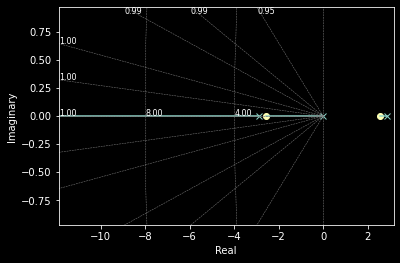

In [ ]:
# Part (a)
# Goal: plot the root locus of the plant.

Gplant = tf([0.00454545454545455,2.69360269362905*10**-5,-0.0297272727272727],[1,0.0202693602693603,-8.32356094276094,-0.0832363636363636])
r,k=root_locus(Gplant)

In [ ]:
# Goal: Using the pole assignment to set up the transfer function of our controller.

var('d2 d1 d0 c0 c1')
Gc = (d2*s**2+d1*s+d0)/(s**2+c1*s+c0)
T =  (G0*Gc/(1+G0*Gc)).simplify()
n,d = fraction(T)
d = collect(d.expand(),s)
d

                                                  5    4                      
-0.0832363636363636⋅c₀ - 0.0297272727272727⋅d₀ + s  + s ⋅(c₁ + 0.0045454545454

                                 3                                            
5455⋅d₂ + 0.0202693602693603) + s ⋅(c₀ + 0.0202693602693603⋅c₁ + 0.00454545454

                                                          2                   
545455⋅d₁ + 2.69360269362905e-5⋅d₂ - 8.32356094276094) + s ⋅(0.020269360269360

                                                                              
3⋅c₀ - 8.32356094276094⋅c₁ + 0.00454545454545455⋅d₀ + 2.69360269362905e-5⋅d₁ -

                                                                              
 0.0297272727272727⋅d₂ - 0.0832363636363636) + s⋅(-8.32356094276094⋅c₀ - 0.083

                                                                  
2363636363636⋅c₁ + 2.69360269362905e-5⋅d₀ - 0.0297272727272727⋅d₁)

In [ ]:
# Goal: Sovle for the coefficients of the transfer function of our controller with the desired poles.

charpoly = (s+0.045)*(s+0.04)*(s+0.035)*(s+0.03)*(s+0.025)
soln = solve(d-charpoly,[c0,c1,d0,d1,d2])
soln

{c₀: -30.5644636647653, c₁: -0.614245374459803, d₀: 85.5804966718933, d₁: 8559
.76947615152, d₂: 169.174723121897}

In [ ]:
# Goal: Plug in the coefficients to the transfer function of our controller.

Gcon = Gc.subs(soln)
Gcon

                  2                                        
169.174723121897⋅s  + 8559.76947615152⋅s + 85.5804966718933
───────────────────────────────────────────────────────────
         2                                                 
        s  - 0.614245374459803⋅s - 30.5644636647653        

In [ ]:
# Goal: Plug in the coefficients to the transfer function of our closed loop system.

T = T.subs(soln).simplify()
T

            ⎛                   4                    3                     2  
        1.0⋅⎝0.768976014190444⋅s  + 38.912599968315⋅s  - 4.40953469402792⋅s  -
──────────────────────────────────────────────────────────────────────────────
     5                      4                       3                         
1.0⋅s  + 0.175000000000001⋅s  + 0.0121250000000401⋅s  + 0.000415624999999586⋅s

                                      ⎞        
 254.456296501577⋅s - 2.54407476470083⎠        
───────────────────────────────────────────────
2                                              
  + 7.04625000480519e-6⋅s + 4.72500003567689e-8

In [ ]:
# Goal: Find the zeros and poles of the transfer function of our closed loop system.

num1,den1 = fraction(T)
zeros1 = solve(num1,s)
poles1 = solve(den1,s)
zeros1, poles1

([-50.58721289174 - 3.04744201263019e-30⋅ⅈ, -2.56030704993086 - 1.145724450396
06e-29⋅ⅈ, -0.00999996720375752 + 8.60036598881911e-29⋅ⅈ, 2.55438112400487 - 7.
14989733716003e-29⋅ⅈ], [-0.0450000090694885, -0.0399999569776338, -0.035000074
5441765, -0.0299999436916809, -0.0250000157170203])

771 0.9999999999999227 [-0.04015424+0.j -0.02498054+0.j -0.04495329+0.j -0.03480459+0.j
 -0.03010735+0.j]


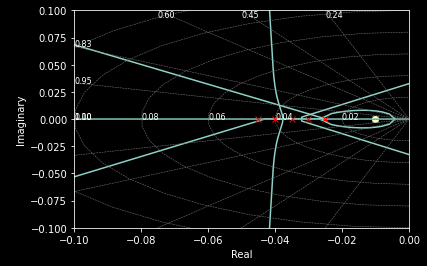

In [ ]:
# Goal: Plot the root locus of the controller and mark the desired poles we picked with red xs.
# Find the corresponding K value that gives the closet desired poles.

Gcontrol = tf([169.174723121897,8559.76947615152,85.5804966718933],[1,-0.614245374459803,-30.5644636647653])
roots,klist = root_locus(Gplant*Gcontrol,xlim=(-0.1,0),ylim=(-0.1,0.1))

diff = np.zeros(len(klist))
for i in range(0, len(klist)):
  diff[i] = abs(klist[i]-1)
k = diff.argmin()
print(k, klist[k],roots[k])
polesK1 = plt.plot(np.real(roots[k]), np.imag(roots[k]),'xr',label="K=1")

In [ ]:
# Part (b)
# Goal: Find gain margin of K values that maintain the stability of our system.

for ii in range(len(roots)):
  poles = roots[ii, :]
  isNegative = True
  for i in range(len(poles)):
    pole = poles[i]
    if np.real(pole) > 0:
      isNegative = False
  if isNegative == True:
    print("K=", klist[ii], "gives poles: ", np.real(poles))

K= 0.9999999999986545 gives poles:  [-0.0431471  -0.02470298 -0.0431559  -0.03199701 -0.03199701]
K= 0.9999999999992152 gives poles:  [-0.04145458 -0.02481718 -0.04440831 -0.03218091 -0.03213902]
K= 0.999999999999569 gives poles:  [-0.04081133 -0.02489575 -0.04471364 -0.03388427 -0.03069501]
K= 0.9999999999999227 gives poles:  [-0.04015424 -0.02498054 -0.04495329 -0.03480459 -0.03010735]
K= 1.0000000000002767 gives poles:  [-0.03937764 -0.02507288 -0.04515455 -0.0357446  -0.02965032]
K= 1.0000000000006304 gives poles:  [-0.03762086 -0.02517456 -0.04532982 -0.03762086 -0.0292539 ]
K= 1.0000000000026708 gives poles:  [-0.03781626 -0.02666026 -0.04607432 -0.03781626 -0.02663291]
K= 1.0000000000665765 gives poles:  [-0.03864549 -0.02310603 -0.05149696 -0.03864549 -0.02310603]
K= 1.0000000001304823 gives poles:  [-0.03887753 -0.02184903 -0.05354689 -0.03887753 -0.02184903]
K= 1.0000000001943883 gives poles:  [-0.03902177 -0.02100149 -0.05495348 -0.03902177 -0.02100149]
K= 1.000000000258294 

In [ ]:
# Goal: Find the numerator and denominator of the transfer function of our closed loop system.

numT, denT = fraction(T)
numT, denT

⎛                   4                    3                     2              
⎝0.768976014190444⋅s  + 38.912599968315⋅s  - 4.40953469402792⋅s  - 254.4562965

                                 5                      4                     
01577⋅s - 2.54407476470083, 1.0⋅s  + 0.175000000000001⋅s  + 0.0121250000000401

  3                         2                                              ⎞
⋅s  + 0.000415624999999586⋅s  + 7.04625000480519e-6⋅s + 4.72500003567689e-8⎠

(7.980722487195042, 9.22657610254333, 0.1089786458286267)

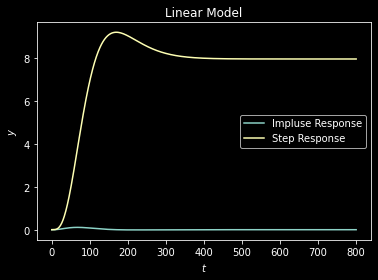

In [ ]:
# Part (c)
# Goal: Plot the step response and impulse response of the linear model of our system. 
# To get a performant response, we divide the input by a gain of −6750000.

k_y = -6750000
system = ctrl.TransferFunction([0.768976014190444,38.912599968315,-4.40953469402792,-254.456296501577,-2.54407476470083],[1,0.175000000000001,0.0121250000000401,0.000415624999999586,7.04625000480519*10**-6,4.72500003567689*10**-8])
ti,yi = impulse_response(system,np.linspace(0,800,1000))
ts,ys = step_response(system,np.linspace(0,800,1000))
plt.plot(ti,yi/k_y,label='Impluse Response')
plt.plot(ts,ys/k_y,label='Step Response')
plt.title("Linear Model")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend()
Vss = np.mean(ys[500:999]/k_y)
Vmaxi = max(yi/k_y)
Vmaxs = max(ys/k_y)
Vss, Vmaxs, Vmaxi

In [ ]:
print("Step response \n Settling time = ", find_Ts(ys/k_y, ts, 1), "\n Overshoot = ", find_OS(ys/k_y), "\n Settling response = ", find_avg(ys/k_y), "\n Max response =", max(ys/k_y))
print("Impulse response \n Max response =", max(yi/k_y))

Step response 
 Settling time =  325.9259259259259 
 Overshoot =  0.1566772327863295 
 Settling response =  7.9767940796391 
 Max response = 9.22657610254333
Impulse response 
 Max response = 0.1089786458286267


In [ ]:
# Goal: Find the state space representation of the transfer function of our closed loop system to plot the non linear model.

Controller = tf2ss(Gcontrol)
Controller

A = [[ 0.61424537 30.56446366]
 [ 1.          0.        ]]

B = [[1.]
 [0.]]

C = [[8663.6842673  5256.31517453]]

D = [[169.17472312]]

8.025367965904223 7.950088267007105


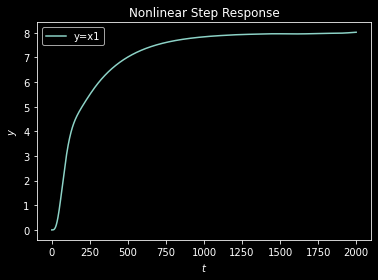

In [ ]:
# Goal: Plot the nonlinear step response. To get a performant response, we divide the input by a gain of −15100000.

def rfn(t):
  if t >= 0:
    return (1 / -15100000)
  else:
    return 0

def ffn(x,t):
  r = rfn(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Step Response")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])
print(max(x_of_t[:,0]), np.mean(x_of_t[5000:9999, 0]))

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  963.096309630963 
 Overshoot =  0.00602324935648317 
 Settling response =  7.977318586859461 
 Max response = 8.025367965904223


0.047574664343315275


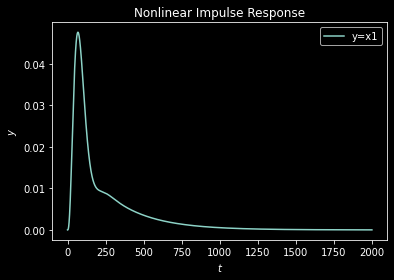

In [ ]:
# Goal: Plot the nonlinear impulse response. To get a performant response, we divide the input by a gain of −15100000.

def aim(t):
    dt = 0.1
    if (t >= 0 and t < dt):
      return 1/(dt * -15100000)
    else:
      return 0

def ffn(x,t):
  r = aim(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Impulse Response")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])
print(max(x_of_t[:,0]))

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 0.047574664343315275


## Task 5:  Disturbances and Noise

a) Occasionally, the scooter may encounter a hill, wind or other exogenous force. Determine a model of this kind of disturbance, and
discuss its effect on the root locus controlled system.

b) Over time the scooter's tires may wear or go flat. Discuss the sensitivity of the system to changes in the tire's radius $R$ for your Root locus designed system. Note that for some analysis sensitivity $S^f_R$ for some $f$ may be informative (such as in the sensitivity notes) and sometimes just examining how other metrics change with $R$ is informative (such as in the mag lev example). Pick what you feel is justified.

optional: repeat the above after designing the fullstate feedback + observer controller (after task 7).  Label this Task 7.5.

## Disturbances and Noise

The block diagram with disturbace and noise is shown as below.
<img width=57.5% src="https://github.com/christakahashi/ECE447/blob/master/images/blocks-with-dist-and-noise.png?raw=1">

In our system, we assume noise is zero ($N(s) = 0$). The possible disturbances are a gust of wind and climbing on a hill. We modeled a gust of wind as an impulse input and climbing on a hill as a step input. Thus, we plot the step response and impulse response of the system with a gust of wind as $D(s) = 1$ and with a hill as $D(s) = 1/s$. 

From the block diagram, the transfer function of the system with the disturbance is $T(s) = \frac{Y(s)}{R(s)} = \frac{(R(s)Gc(s)+D(s))G(s)}{(1+Gc(s)G(s))R(s)}$ 

### Linear Model
A gust of wind does not affect the velocity of the scooter a lot. For step response with a gust of wind, the steady-state velocity of the scooter is $7.98 m/s$ and the percent overshoot is $15.5$% which is similar to the percent overshoot without the disturbance. For impulse response with a gust of wind, the maximum velocity of the scooter is $0.098 m/s$. As a result, we can see the disturbance of a gust of wind does not affect our system's performance that much.

From our plots of step response and impulse response, climbing on a hill decreases the velocity of the scooter in general which is consistent with reality. For step response with a hill, the steady-state velocity of the scooter is $5.13 m/s$ and the percent overshoot is $46.2$%. For impulse response with a hill, the maximum velocity of the scooter is $0.041 m/s$. As a result, we can see that the disturbance of climbing on a hill affects our system performance by decreasing the velocity of the scooter. 

### Nonlinear Model
For the nonlinear model, it can only handle very small disturbances since we need to divide the disturbance by a gain of $-15100000$ to get a performant response. 

For step response with a gust of wind, the steady-state velocity of the scooter is $7.96 m/s$. For impulse response with a gust of wind, the maximum velocity of the scooter is $0.043 m/s$. Similar to the linear model, we can see that the disturbance of a gust of wind does not affect our system's performance that much.

For step response with a hill, the steady-state velocity of the scooter is $5.11 m/s$. For impulse response with a hill, the maximum velocity of the scooter is $0.017 m/s$. Similar to the linear model, we can see that the disturbance of climbing on a hill affects our system performance by decreasing the velocity of the scooter. 

## Sensitivity
We analyzed the sensitivity of the plant and the transfer function to changes in the tire's radius $R$ for our root locus designed system. 

The sensitivity of the plant to changes in the tire's radius $R$ is 1 which means changes in the plant and changes in $R$ are proportional. This is consistent with our model since if the tire gets flat, the velocity of the scooter will be affected directly.

The sensitivity of the transfer function to changes in the tire's radius $R$ is plotted below. Both plots show how the sensitivity changes with varying frequency and radius. We can see that the sensitivity eventually becomes close to zero with higher frequency in the first plot and the sensitivity is higher with a larger radius value at low frequencies in both plots. Although it seems counterintuitive that the sensitivity is higher with a larger radius, we can interpret it as the sensitivity is higher with a larger change in radius instead. The reason for the inconsistency is that the two equations given for the model may not be correct.



In [ ]:
# Part (a)
# Goal: Find the transfer functions for step input step disturbance, step input impulse disturbance, 
# impulse input step disturbance, and impulse input impulse disturbance.
# Find the coefficients of numerator and denominator of each transfer function.

Ds = 1/s
Di = 1
Rs = 1/s
Ri = 1
Tdss = (((Rs*Gcon+Ds)*G0) / ((1+Gcon*G0)*Rs)).simplify().cancel()
Tdsi = (((Rs*Gcon+Di)*G0) / ((1+Gcon*G0)*Rs)).simplify().cancel()
Tdis = (((Ri*Gcon+Ds)*G0) / ((1+Gcon*G0)*Ri)).simplify().cancel()
Tdii = (((Ri*Gcon+Di)*G0) / ((1+Gcon*G0)*Ri)).simplify().cancel()

numTdss, denTdss = fraction(Tdss)
numTdsi, denTdsi = fraction(Tdsi)
numTdis, denTdis = fraction(Tdis)
numTdii, denTdii = fraction(Tdii)
numSS = Poly(numTdss,s).all_coeffs()
denSS = Poly(denTdss,s).all_coeffs()
numSI = Poly(numTdsi,s).all_coeffs()
denSI = Poly(denTdsi,s).all_coeffs()
numIS = Poly(numTdis,s).all_coeffs()
denIS = Poly(denTdis,s).all_coeffs()
numII = Poly(numTdii,s).all_coeffs()
denII = Poly(denTdii,s).all_coeffs()
numSS, denSS

([0.773521468735898, 38.9098348799126, -4.57820789237953, -254.438859947025, -
1.63547661757553], [1.0, 0.175000000000001, 0.0121250000000401, 0.000415624999
999586, 7.04625000480519e-6, 4.72500003567689e-8])

In [ ]:
# Goal: Find the coefficients of numerator and denominator of each transfer function.

numSI, denSI

([0.00454545454545455, 0.766210925788017, 38.7439267699634, -4.39209813947646,
 -253.547698354452, -2.54407476470083], [1.0, 0.175000000000001, 0.01212500000
00401, 0.000415624999999586, 7.04625000480519e-6, 4.72500003567689e-8])

In [ ]:
# Goal: Find the coefficients of numerator and denominator of each transfer function.

numIS, denIS

([0.768976014190444, 38.9171454228605, -4.41229978243035, -254.624969699928, -
2.52663821014936, 0.908598147125295], [1.0, 0.175000000000001, 0.0121250000000
401, 0.000415624999999586, 7.04625000480519e-6, 4.72500003567689e-8, 0.0])

In [ ]:
# Goal: Find the coefficients of numerator and denominator of each transfer function.

numII, denII

([0.773521468735898, 38.9098348799126, -4.57820789237953, -254.438859947025, -
1.63547661757553], [1.0, 0.175000000000001, 0.0121250000000401, 0.000415624999
999586, 7.04625000480519e-6, 4.72500003567689e-8])

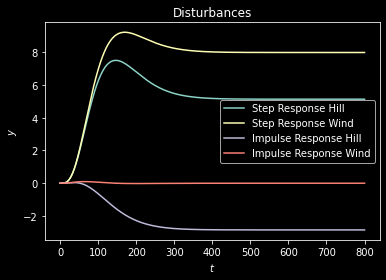

In [ ]:
# Goal: Plot the step response and impulse response of the system with the step disturbance and the impulse disturbance respectively.
# Find the maximum and steady-state velocities of each response and find the percent overshoot of the step responses. 

tDss = ctrl.TransferFunction([0.773521468735898,38.9098348799126,-4.57820789237953,-254.438859947025,-1.63547661757553],[1,0.175000000000001,0.0121250000000401,0.000415624999999586,7.04625000480519*10**-6,4.72500003567689*10**-8])
tDsi = ctrl.TransferFunction([0.00454545454545455,0.766210925788017,38.7439267699634,-4.39209813947646,-253.547698354452,-2.54407476470083],[1,0.175000000000001,0.0121250000000401,0.000415624999999586,7.04625000480519*10**-6,4.72500003567689*10**-8])
tDis = ctrl.TransferFunction([0.768976014190444,38.9171454228605,-4.41229978243035,-254.624969699928,-2.52663821014936,0.908598147125295],[1,0.175000000000001,0.0121250000000401,0.000415624999999586,7.04625000480519*10**-6,4.72500003567689*10**-8,0])
tDii = ctrl.TransferFunction([0.773521468735898,38.9098348799126,-4.57820789237953,-254.438859947025,-1.63547661757553],[1,0.175000000000001,0.0121250000000401,0.000415624999999586,7.04625000480519*10**-6,4.72500003567689*10**-8])

tdss,ydss = step_response(tDss,np.linspace(0,800,1000))
tdsi,ydsi = step_response(tDsi,np.linspace(0,800,1000))
tdis,ydis = impulse_response(tDis,np.linspace(0,800,1000))
tdii,ydii = impulse_response(tDii,np.linspace(0,800,1000))

plt.plot(tdss,ydss/k_y,label='Step Response Hill')
plt.plot(tdsi,ydsi/k_y,label='Step Response Wind')
plt.plot(tdis,ydis/k_y,label='Impulse Response Hill')
plt.plot(tdii,ydii/k_y,label='Impulse Response Wind')
plt.title("Disturbances")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend()

In [ ]:
print("Step Response Hill\n Settling time = ", find_Ts(ydss/k_y, tdss, 1), "\n Overshoot = ", find_OS(ydss/k_y), "\n Settling response = ", find_avg(ydss/k_y), "\n Max response =", max(ydss/k_y))
print("Step Response Wind\n Settling time = ", find_Ts(ydsi/k_y, tdsi, 1), "\n Overshoot = ", find_OS(ydsi/k_y), "\n Settling response = ", find_avg(ydsi/k_y), "\n Max response =", max(ydsi/k_y))
print("Impulse Response Hill\n Settling response = ", find_avg(ydis/k_y), "\n Max response =", max(ydis/k_y))
print("Impulse Response Wind\n Settling response = ", find_avg(ydii/k_y), "\n Max response =", max(ydii/k_y))

Step Response Hill
 Settling time =  361.1611611611612 
 Overshoot =  0.4620159705827137 
 Settling response =  5.127984715864094 
 Max response = 7.497195551497365
Step Response Wind
 Settling time =  325.1251251251251 
 Overshoot =  0.15494875227877966 
 Settling response =  7.976793622471981 
 Max response = 9.212787841459342
Impulse Response Hill
 Settling response =  -2.848811173152345 
 Max response = 0.040816757440559986
Impulse Response Wind
 Settling response =  -2.2665444058435252e-06 
 Max response = 0.09833390708068089


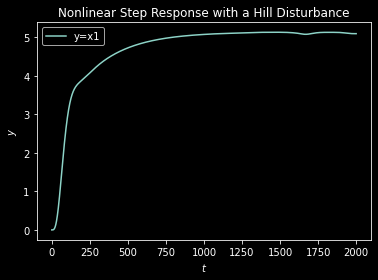

In [ ]:
# Goal: Plot the nonlinear step response with the step disturbance and find the maximum and steady-state velocities of the response.

var('dis')
def ffn(x,t):
  r = rfn(t)
  dis = rfn(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1 + dis
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Step Response with a Hill Disturbance")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  812.2812281228122 
 Overshoot =  0.0036267114955877296 
 Settling response =  5.109480539833 
 Max response = 5.128011151643294


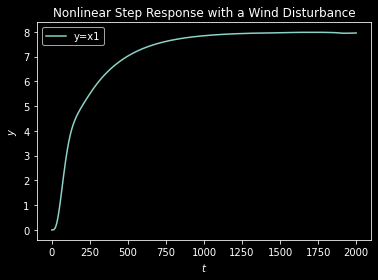

In [ ]:
# Goal: Plot the nonlinear step response with the impulse disturbance and find the maximum and steady-state velocities of the response.

def ffn(x,t):
  r = rfn(t)
  dis = aim(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1  + dis
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Step Response with a Wind Disturbance")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  945.6945694569456 
 Overshoot =  0.0018299553392818711 
 Settling response =  7.9649764643048835 
 Max response = 7.979552015512993


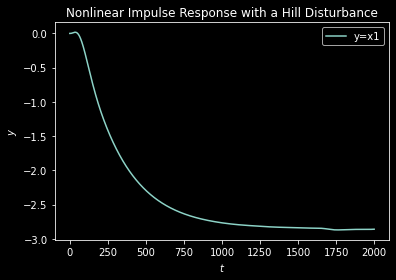

In [ ]:
# Goal: Plot the nonlinear impulse response with the step disturbance and find the maximum and steady-state velocities of the response.

def ffn(x,t):
  r = aim(t)
  dis = rfn(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1 + dis
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Impulse Response with a Hill Disturbance")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])

In [ ]:
print(" Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling response =  -2.858164414584102 
 Max response = 0.01727240984724698


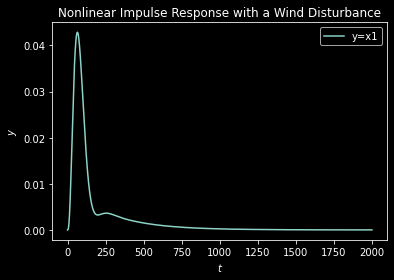

In [ ]:
# Goal: Plot the nonlinear impulse response with the impulse disturbance and find the maximum and steady-state velocities of the response.

def ffn(x,t):
  r = aim(t)
  dis = aim(t)

  # extract x1,x2,x3,x4,x5 from input
  x1 = x[0]
  x2 = x[1]
  x3 = x[2]
  x4 = x[3]
  x5 = x[4]

  # compute f(x,t)
  Tau = 8663.6842673 * x4 + 5256.31517453 * x5 + 169.17472312 * r - 169.17472312 * x1 + dis
  x1dot = (-23.625 * x1 + 8.4375 * Tau - 759.375 * x3**2 * np.sin(x2) - 4.5 * x3 * np.cos(x2) + 2483.15625 * np.sin(2*x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x2dot = x3
  x3dot = (-15.75 * x1 * np.cos(x2) + 5.625 * Tau * np.cos(x2) - 253.125 * x3**2 * np.sin(2*x2) - 14 * x3 + 15450.75 * np.sin(x2)) / (506.25 * np.sin(x2)**2 + 1856.25)
  x4dot = 0.61424537 * x4 + 30.56446366 * x5 + r - x1
  x5dot = x4

  # return derivatives.
  return [x1dot,x2dot,x3dot,x4dot,x5dot]

t = np.linspace(0,2000,10000)
x_of_t = spi.odeint(ffn,(0,0,0,0,0),t)
plt.figure()
plt.plot(t,x_of_t[:,0])
plt.title("Nonlinear Impulse Response with a Wind Disturbance")
plt.xlabel("$t$")
plt.ylabel("$y$")
plt.legend(["y=x1","x2","x3", "x4", "x5"])

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 0.0428566735789348


In [ ]:
# Part (b)
# Goal: Find the transfer function of the plant in terms of the radius R.

PhiGP = (s*eye(3)-A).inv()
GP = C*PhiGP*B
GP.simplify()
GP = (GP.subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81))[0]
GP

          ⎛       2                  ⎞        
        R⋅⎝33.75⋅s  + 0.2⋅s - 220.725⎠        
──────────────────────────────────────────────
         3           2                        
1856.25⋅s  + 37.625⋅s  - 15450.61⋅s - 154.5075

In [ ]:
# Goal: Find the sensitivity of the plant to changes in the tire's radius R.

SGR = ((GP.diff(R))*R / GP).simplify()
SGR

1

In [ ]:
# Goal: Find the transfer function of our closed loop system in terms of R. 

GcS = Gc.subs(soln)
TS = ((GP*GcS) / (1+GP*GcS)).simplify()
GcS,TS

⎛                  2                                                          
⎜169.174723121897⋅s  + 8559.76947615152⋅s + 85.5804966718933                  
⎜───────────────────────────────────────────────────────────, ────────────────
⎜         2                                                     ⎛       2     
⎝        s  - 0.614245374459803⋅s - 30.5644636647653          R⋅⎝33.75⋅s  + 0.

                                    ⎛       2                  ⎞ ⎛            
                                  R⋅⎝33.75⋅s  + 0.2⋅s - 220.725⎠⋅⎝169.17472312
──────────────────────────────────────────────────────────────────────────────
             ⎞ ⎛                  2                                        ⎞  
2⋅s - 220.725⎠⋅⎝169.174723121897⋅s  + 8559.76947615152⋅s + 85.5804966718933⎠ -

      2                                        ⎞                              
1897⋅s  + 8559.76947615152⋅s + 85.5804966718933⎠                              
──────────────────────────────────────────────────

In [ ]:
# Goal: Find the sensitivity of the transfer function of our closed loop system to changes in the tire's radius R.

STR = (TS.diff(R)*R / TS).simplify()
STR

                                                ⎛   2                         
                                               -⎝- s  + 0.614245374459803⋅s + 
──────────────────────────────────────────────────────────────────────────────
  ⎛       2                  ⎞ ⎛                  2                           
R⋅⎝33.75⋅s  + 0.2⋅s - 220.725⎠⋅⎝169.174723121897⋅s  + 8559.76947615152⋅s + 85.

                ⎞ ⎛         3           2                        ⎞            
30.5644636647653⎠⋅⎝1856.25⋅s  + 37.625⋅s  - 15450.61⋅s - 154.5075⎠            
──────────────────────────────────────────────────────────────────────────────
             ⎞   ⎛   2                                         ⎞ ⎛         3  
5804966718933⎠ - ⎝- s  + 0.614245374459803⋅s + 30.5644636647653⎠⋅⎝1856.25⋅s  +

                                   
                                   
───────────────────────────────────
         2                        ⎞
 37.625⋅s  - 15450.61⋅s - 154.5075⎠

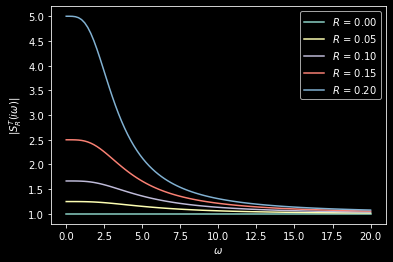

In [ ]:
# Goal: Plot the sensitivity of the transfer function of our closed loop system to changes in the tire's radius R with varying frequency and radius.
# Sensitivity is on the y axis and frequency is on the x axis.

omegas = np.linspace(0,20,100)

for r in (0,0.05,0.1,0.15,0.2):
  STr = STR.subs(R,r).simplify()
  y = [np.abs(N(STr.subs(s,omega*I))) for omega in omegas]
  plt.plot(omegas, y,label="$R$ = %.2f" % (r))
plt.xlabel("$\omega$")
plt.ylabel("$|S_R^T(i \omega)|$")
plt.legend();

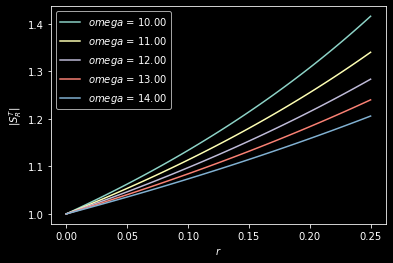

In [ ]:
# Goal: Plot the sensitivity of the transfer function of our closed loop system to changes in the tire's radius R with varying frequency and radius.
# Sensitivity is on the y axis and radius is on the x axis.

rs = np.linspace(0,0.25,100)

for omega in (10,11,12,13,14):
  STr = STR.subs(s,omega*I).simplify()
  y = [np.abs(N(STr.subs(R,r))) for r in rs]
  plt.plot(rs, y,label="$omega$ = %.2f" % (omega))
plt.xlabel("$r$")
plt.ylabel("$|S_R^T|$")
plt.legend();

## Task 6: Full State Feedback

Determine whether the system is controllable. If it is, design a full state feedback controller to obtain the desired performance. Plot the impulse response of the controlled system
with the linear model and the nonlinear model.  You may scale the impulse imput up or down if you feel it doesn't give a good characterization. 

You may use either pole placement or LQR (if we end up covering it in time).  If you pick pole placement make sure to explain your choice of poles.  If you pick LQR explain your method for picking weights even if it's just guess-and-check, where did you start and how did you adjust them to get what you wanted.  



## Controllability

To determine if the system is controllable, we can find the controllability matrix $M$.

$$M = [ B \; AB \; A^2 B]$$

$$ M = 
\begin{pmatrix}
0.00455 & -6.520 \cdot 10^{-5} & 0.008\\
0 & 0.0030 & -6.142 \cdot 10^{-5}\\
0.0030 & -6.142 \cdot 10^{-5} & 0.0252\end{pmatrix}
$$

The rank of this matrix is $3$ which means matrix $M$ is full rank which tells us that the system is controllable.

## Full State Feedback Controller

When designing the FSFB controller, we first need to decide the poles. We picked the poles to be $-0.5, -0.6$, and $-0.7$. We picked these poles because they all need to be negative for the system to be stable. These poles are also further from the imaginary axis than the poles we used in the root locus design. This is because the poles further from the imaginary axis will give us a much faster system while remaining performant. We also avoided poles that were too far away from the imaginary axis because we wanted to keep overshoot to a minimum.

Once we decided on the poles, we can use the `place` command to find the gain matrix $K$. We get that matrix $K$ is:

$$
K = \begin{pmatrix} -9.86422018 & 3099.96279307 & 602.10744139 \end{pmatrix}
$$

The system with a full state feedback controller can be defined as:

$$\dot x = (A-BK)x + Br$$
$$y = Cx$$

$$
\dot x = 
\begin{pmatrix}
0.0321 & -11.415 & -2.739\\
0 & 0 & 1\\
0.0214 & -1.070 & -1.832
\end{pmatrix} x
+
\begin{pmatrix}
0.0045 \\
0 \\
0.0030
\end{pmatrix} r
$$
$$y = \begin{pmatrix} 1 & 0 & 0 \end{pmatrix}$$

## Linear Step and Impulse Response

We can use the `odeint` function with the previous state space representation of our system to model a linear response to our system. The responses are plotted below. We can see that a full state feedback controller makes or system much more performant than the previous root locus controller. The inputs are scaled by $-56.5$ to give a more characteristic response. The linearized FSFB controller gives the step response a settling time of approximately $12.8 s$, a $0.0053\%$ overshoot, and a settling response of $7.99$. An impulse input gives a max response of $1.310$.

## Nonlinear Step and Impulse Response

Rather than using the state space approximation for the plant, we can directly use the function equations to represent the nonlinear response to a step and impulse input. The plots of the step and impulse response are shown below. The inputs are again scaled by $-56.5$ to give a more characteristic response. The nonlinearized FSFB controller gives the step response a settling time of approximately $11.95 s$, a $0.0022\%$ overshoot, and a settling response of $7.99$. An impulse input gives a max response of $1.319$. Since the linearized model is around the initial conditions of $\dot p = 0, \theta = 0, \dot{\theta} = 0$, deviations from these initial conditions will cause the nonlinear model to become unstable and not representative. For our full state feedback controller, we found the system to remain stable as long as all of the initial conditions are between $0.4$ and $-0.3$. Outside of this range of initial values, the nonlinear model shows a series of unstable sinusoids.

In [ ]:
#controllability

def MatrixFromColumns(clist):
    return Matrix(clist).reshape(
        clist[0].shape[0], 
        len(clist)).transpose()

# find the rank of the controllability matrix
Mc = MatrixFromColumns([Beq, Aeq*Beq, Aeq**2*Beq])
rankMc = Mc.rank()
Mc, rankMc

⎛⎡0.00454545454545455  -6.51974288337925e-5  0.00810841670454159 ⎤   ⎞
⎜⎢                                                               ⎥   ⎟
⎜⎢         0           0.00303030303030303   -6.14223038465463e-5⎥, 3⎟
⎜⎢                                                               ⎥   ⎟
⎝⎣0.00303030303030303  -6.14223038465463e-5   0.0252241569385657 ⎦   ⎠

In [ ]:
# Goal: solve the expressions for p double dot and theta double dot from the given two equations.
# Rearrange the given two equations in terms of p double dot.
pLn = (tau * R + m*ell*cos(theta)*thetaddot - c*pdot - m*ell*thetadot**2*sin(theta)) / (M + m)
pRn = ((J + m*ell**2)*thetaddot + gamma*thetadot - m*g*ell*sin(theta)) / (m*ell*cos(theta))

# Rearrange the given two equations in terms of theta double dot.
tLn = ((M + m)*pddot + c*pdot + m*ell*thetadot**2*sin(theta)-tau*R)/(m*ell*cos(theta))
tRn = (m*ell*cos(theta)*pddot - gamma*thetadot + m*g*ell*sin(theta)) / (J + m*ell**2)

# Set the two equations in terms of p double dot equal to each other and use the 
# solve function to find the theta double dot. 
Tddotn = solve(pLn - pRn, thetaddot)

# Set the two equations in terms of theta double dot equal to each other and use 
# the solve function to find the p double dot. 
Pddotn = solve(tLn - tRn, pddot)

Pddotn, Tddotn

⎛⎡                                                                            
⎜⎢                           2               2            2           3  2   2
⎜⎢J⋅R⋅τ - J⋅c⋅ṗ - J⋅ell⋅m⋅θ̇ ⋅sin(θ) + R⋅ell ⋅m⋅τ - c⋅ell ⋅m⋅ṗ - ell ⋅m ⋅θ̇ 
⎜⎢                                                                            
⎜⎢────────────────────────────────────────────────────────────────────────────
⎜⎢                                                            2        2  2   
⎝⎣                                           J⋅M + J⋅m + M⋅ell ⋅m + ell ⋅m ⋅si

             2    2                             ⎤  ⎡                          
          ell ⋅g⋅m ⋅sin(2⋅θ)                    ⎥  ⎢                          
⋅sin(θ) + ────────────────── - ell⋅γ⋅m⋅θ̇⋅cos(θ)⎥  ⎢M⋅ell⋅g⋅m⋅sin(θ) - M⋅γ⋅θ̇ 
                  2                             ⎥  ⎢                          
────────────────────────────────────────────────⎥, ⎢──────────────────────────
 2                                              ⎥  ⎢ 

In [ ]:
# Goal: substitute the values of the given parameters in the equations for p double dot and theta double dot.

P_ddotn = Pddotn[0].subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
T_ddotn = Tddotn[0].subs(M, 40).subs(m, 30).subs(ell, 0.75).subs(c, 0.7).subs(R, 0.25).subs(J, (0.75**2)*30).subs(gamma, 0.2).subs(g, 9.81)
P_ddotn, T_ddotn

⎛                                  2                                          
⎜-23.625⋅ṗ + 8.4375⋅τ - 759.375⋅θ̇ ⋅sin(θ) - 4.5⋅θ̇⋅cos(θ) + 2483.15625⋅sin(2
⎜─────────────────────────────────────────────────────────────────────────────
⎜                                      2                                      
⎝                            506.25⋅sin (θ) + 1856.25                         

                                                   2                          
⋅θ)  -15.75⋅ṗ⋅cos(θ) + 5.625⋅τ⋅cos(θ) - 253.125⋅θ̇ ⋅sin(2⋅θ) - 14.0⋅θ̇ + 1545
───, ─────────────────────────────────────────────────────────────────────────
                                             2                                
                                   506.25⋅sin (θ) + 1856.25                   

           ⎞
0.75⋅sin(θ)⎟
───────────⎟
           ⎟
           ⎠

In [ ]:
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
An = np.array(Aeq).astype(np.float64)
Bn = np.array(Beq).astype(np.float64)
Cn = np.array(C).astype(np.float64)

#poles for controller
Cp1 = -0.5
Cp2 = -0.6
Cp3 = -0.7

K = np.array(place(An, Bn, [Cp1, Cp2, Cp3]))
K

array([[  -9.86422018, 3099.96279307,  602.10744139]])

In [ ]:
Ahat = Aeq-Beq*K
Ahat

⎡0.0321100917431408  -11.4152854230385  -2.7392762487265 ⎤
⎢                                                        ⎥
⎢        0                   0                  1        ⎥
⎢                                                        ⎥
⎣0.0214067278287605  -1.07019028202565  -1.83211009174359⎦

Text(0.5, 1.0, 'Linear Step Response')

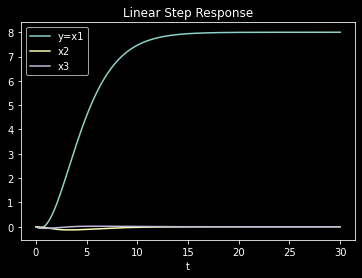

In [ ]:
# Goal: Plot the linear step response
def step_fn(t):
  if t >= 0:
    return 1 * -56.5
  else:
    return 0

def ffn(x,t):
  #extract plant dynamics and make it a column 
  x = np.array([np.array(x[:3])]).transpose()

  #compute r
  r = step_fn(t)

  #compute f(x,t) from linearized state space
  u = (r-K@x).item()
  y = (Cn@x).item()
  xdot = (An@x+Bn*u).flatten()

  #return derivatives. 
  return [xdot[0],xdot[1],xdot[2]]
 
#plot the response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0],t) # initial values
plt.figure()
plt.plot(t,x_of_t)
plt.legend(["y=x1","x2","x3"])
plt.xlabel("t")
plt.title("Linear Step Response")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.792792792792792 
 Overshoot =  5.2898995157395373e-05 
 Settling response =  7.99758338933246 
 Max response = 7.998006453457443


Text(0.5, 1.0, 'Linear Impulse Response')

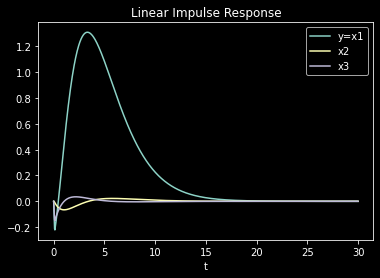

In [ ]:
# Goal: Plot the linear impulse response
def approx_impulse(t):
    dt = 0.1
    if (t >= 0 and t < dt):
      return 1/dt * -56.5
    else:
      return 0

def ffn(x,t ):
  #extract plant dynamics and make it a column
  x = np.array([np.array(x[:3])]).transpose()

  #compute r
  r = approx_impulse(t)

  #compute f(x,t) from linearized state space
  u = (r-K@x).item()
  y = (Cn@x).item()
  xdot = (An@x+Bn*u).flatten()

  #return derivatives.
  return [xdot[0],xdot[1],xdot[2]]
 
#plot the response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0],t) #initial values
plt.figure()
plt.plot(t,x_of_t)
plt.legend(["y=x1","x2","x3"])
plt.xlabel("t")
plt.title("Linear Impulse Response")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.3095764110496544


Text(0.5, 1.0, 'Nonlinear Step Response')

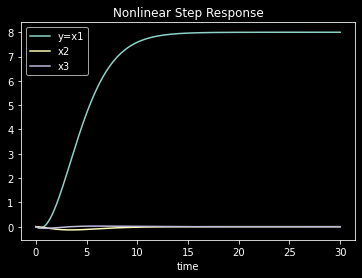

In [ ]:
# Goal: Plot the nonlinear step response
def step_fn(t):
  if t >= 0:
    return 1 * -56.5
  else:
    return 0

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

def ffn(x,t):
  #extract plant dynamics and make it a column
  pdot,theta,thetadot = x[:3]
 
  #compute r
  r = step_fn(t)

  #compute fp(x,u) from nonlinear functions
  u = (r-K@x).item()
  y = pdot
  xdot = fp(pdot,theta,thetadot,u).flatten()
  
  #return derivatives
  return [xdot[0],xdot[1],xdot[2]]

#plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0],t) # initial values
plt.figure()
plt.plot(t,x_of_t)
plt.legend(["y=x1","x2","x3"])
plt.xlabel("time") ;
plt.title("Nonlinear Step Response")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  11.951951951951951 
 Overshoot =  2.1884899899236623e-05 
 Settling response =  7.997860568581933 
 Max response = 7.998035600959884


Text(0.5, 1.0, 'Nonlinear Impulse Response')

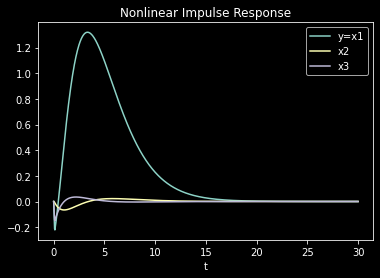

In [ ]:
# Goal: Plot the nonlinear impulse response
def approx_impulse(t):
    dt = 0.1
    if (t >= 0 and t < dt):
      return 1/dt * -56.5
    else:
      return 0

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

def ffn(x,t):
  #extract plant dynamics and make it a column
  pdot,theta,thetadot = x[:3] 
 
  #compute r
  r = approx_impulse(t)

  #compute fp(x,u) from nonlinear functions
  u = (r-K@x).item()
  y = pdot
  yhat = (Cn@x).item()
  xdot = fp(pdot,theta,thetadot,u).flatten()
  
  #return derivatives
  return [xdot[0],xdot[1],xdot[2]]

#plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0],t) #start at x=(0,0,0,0,0,0)^T
plt.figure()
plt.plot(t,x_of_t)
plt.legend(["y=x1","x2","x3"])
plt.xlabel("t") ;
plt.title("Nonlinear Impulse Response")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.3193090514929904


## Task 7: Observer Design

a) While angle and angular velocity sensors exist, they do cost money.  Rather than paying for additional sensors, determine whether the system is observable (it is). If it is,
design an observer for the system. Explain your choice of observer gains.

b) Using your full state controller and the observer, plot the impulse response using the
linear and the nonlinear model.  

## Observability

To determine if the system is observable, we can find the observability matrix $O$.

$$
\mathcal{O} = \begin{pmatrix}
C \\
CA \\
C A^2
\end{pmatrix}
$$

$$
\mathcal{O} = 
\begin{pmatrix}1 & 0 & 0 \\
-0.0127 & 2.675 & -0.00242 \\
0.000183 & -0.0542 & 2.676
\end{pmatrix}
$$

The rank of this matrix is $3$ which tells us that the system is observable.

## Full State Feedback Controller with Observer

We can further develop our FSFB controller by adding an observer. We will use the same matrix $K$ from task 6. When building matrix $L$ for the observer, we picked poles at $-3, -4$, and $-5$. The poles picked as such because they need to be about five times larger than the dominant poles of the plant for the system to respond quickly, but without much overshoot. Using the `place` function, we can find Matrix $L$.

$$
L = \begin{pmatrix}
5.980 \\
7.225 \\
20.877 \\
\end{pmatrix}
$$

We can then find the full system state space representation to be:

$$\begin{align}
\begin{pmatrix}
\dot{x} \\
\dot{\hat{x}}
\end{pmatrix} & = 
\begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix} + \begin{pmatrix}
B \\
B
\end{pmatrix} r \\
y & = ( \; C \;  0 \; ) \; \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix}
\end{align}$$

$$\begin{align}
\begin{pmatrix}
\dot{x} \\
\dot{\hat{x}}
\end{pmatrix} & = 
\begin{pmatrix}-0.0127 & 2.675 & -0.0024 & 0.0311 & -13.596 & -2.266\\
0 & 0 & 1 & 0 & 0 & 0\\
-0.0085 & 8.323 & -0.0075 & 0.0207 & -9.064 & -1.511\\
5.980 & 0 & 0 & -5.961 & -10.920 & -2.269\\
7.225 & 0 & 0 & -7.225 & 0 & 1\\
20.877 & 0 & 0 & -20.865 & -0.740 & -1.518\end{pmatrix} \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix} + \begin{pmatrix}
0.0045 \\
0 \\
0.0030 \\
0.0045 \\
0 \\
0.0030
\end{pmatrix} r \\
y & = ( \; 1 \; 0 \; 0 \; 0 \; 0 \; 0 \; ) \; \begin{pmatrix}
x \\
\hat{x}
\end{pmatrix}
\end{align}$$

## Linear Step and Impulse Response

We can use the `odeint` function with the previous state space representation of our system to model a linear response to our system. The responses are plotted below. We can see that a full state feedback controller makes or system much more performant than the previous root locus controller. The inputs are scaled by $-56.5$ to give a more characteristic response. The linearized FSFB controller with observer gives the step response a settling time of approximately $12.8 s$, a $0.0053\%$ overshoot, and a settling response of $7.99$. An impulse input gives a max response of $1.310$.

## Nonlinear Step and Impulse Response

Rather than using the state space approximation for the plant, we can directly use the function equations to represent the nonlinear response to a step and impulse input. The plots of the step and impulse response are shown below. The inputs are again scaled by $-56.5$ to give a more characteristic response. The nonlinearized FSFB controller with observer gives the step response a settling time of approximately $12.73 s$, a $0.0047\%$ overshoot, and a settling response of $7.99$. An impulse input gives a max response of $1.308$. Since the linearized model is around the initial conditions of $\dot p = 0, \theta = 0, \dot{\theta} = 0$, deviations from these initial conditions will cause the nonlinear model to become unstable and not representative. For our full state feedback controller, we found the system to remain stable as long as all of the initial conditions are between $0.1$ and $-0.1$. Outside of this range of initial values, the nonlinear model shows a single unstable peak response.

In [ ]:
# Part (a)
# observability: finding the observability matrix and rank to determine if the system is observable

O = Matrix([C,C*Aeq,C*Aeq**2])
rankO = O.rank()
O, rankO

⎛⎡         1                     0                    0          ⎤   ⎞
⎜⎢                                                               ⎥   ⎟
⎜⎢-0.0127272727272727    2.67545454545455    -0.00242424242424242⎥, 3⎟
⎜⎢                                                               ⎥   ⎟
⎝⎣0.000182552800734619  -0.0542297520661157    2.67550368329762  ⎦   ⎠

In [ ]:
# Part (a)
# poles for observer, use the place function to determine matrix L for the observer gains

Op1 = -3
Op2 = -4
Op3 = -5

L = np.array(np.transpose(place(np.transpose(An),np.transpose(Cn), [Op1, Op2, Op3])))
L

array([[11.97973064],
       [20.6985399 ],
       [59.72748003]])

In [ ]:
# using the observer gain matrix L to determine the new state space representation for the system
LC = L*C
LC, Ahat - LC

⎛⎡11.9797306397307  0  0⎤  ⎡-11.9476205479876  -11.4152854230385  -2.739276248
⎜⎢                      ⎥  ⎢                                                  
⎜⎢20.698539898807   0  0⎥, ⎢-20.698539898807           0                  1   
⎜⎢                      ⎥  ⎢                                                  
⎝⎣59.7274800330873  0  0⎦  ⎣-59.7060733052585  -1.07019028202565  -1.832110091

7265 ⎤⎞
     ⎥⎟
     ⎥⎟
     ⎥⎟
74359⎦⎠

Text(0.5, 0, 't')

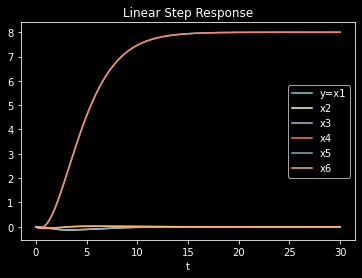

In [ ]:
# Part (b)
# Goal: Plot the linear step response
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  xp = np.array([np.array(x[:3])]).transpose() 
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 

  #compute f(x,t) from linearized state space
  u = (r-K@xo).item()
  y = (Cn@xp).item()
  yhat = (Cn@xo).item()
  xpdot = (An@xp+Bn*u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

#plot the response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Step Response')
plt.legend(["y=x1","x2","x3","x4","x5","x6"])
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.792792792792792 
 Overshoot =  5.2898995157395373e-05 
 Settling response =  7.99758338933246 
 Max response = 7.998006453457443


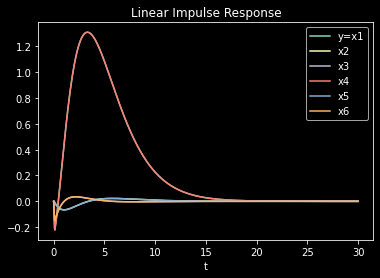

In [ ]:
# Part (b)
# Goal: Plot the linear impulse response
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  xp = np.array([np.array(x[:3])]).transpose() 
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = approx_impulse(t)

  #compute f(x,t) from linearized state space
  u = (r-K@xo).item()
  y = (Cn@xp).item()
  yhat = (Cn@xo).item()
  xpdot = (An@xp+Bn*u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot the response
t = np.linspace(0,30,1000)
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Impulse Response')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t") ;

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.3095764110496544


Text(0.5, 0, 't')

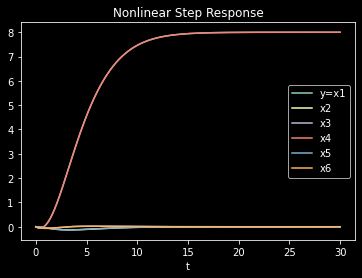

In [ ]:
# Part (b)
# Goal: Plot the nonlinear step response

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 

  #compute output from controller
  u = (r-K@xo).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear functions
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot the response
t = np.linspace(0,30,1000)
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Nonlinear Step Response')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.732732732732732 
 Overshoot =  4.689187273087936e-05 
 Settling response =  7.9976377019872835 
 Max response = 7.998012726196553


Text(0.5, 0, 't')

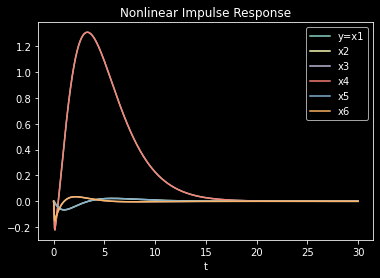

In [ ]:
# Part (b)
# Goal: Plot the nonlinear impulse response

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r
  r = approx_impulse(t) 

  #compute output from controller
  u = (r-K@xo).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear functions
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot the response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Nonlinear Impulse Response')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.3080537049083107


## Task 7.5: Disturbances and Noise
### Linear Model
The full state feedback controller with the observer design handles the disturbances much better than the root locus controller.

A gust of wind does not affect the velocity of the scooter a lot. For step response with a gust of wind, the steady-state velocity of the scooter is $7.998 m/s$ and the percent overshoot is almost $0$% which is similar to the percent overshoot without the disturbance. For impulse response with a gust of wind, the maximum velocity of the scooter is $1.28 m/s$. As a result, we can see the disturbance of a gust of wind does not affect our system's performance that much.

From our plots of step response and impulse response, climbing on a hill decreases the velocity of the scooter in general which is consistent with reality. For step response with a hill, the steady-state velocity of the scooter is $7.86 m/s$ and the percent overshoot is almost $0$%. For impulse response with a hill, the maximum velocity of the scooter is $1.26 m/s$. As a result, we can see that the disturbance of climbing on a hill affects our system performance by decreasing the velocity of the scooter. 

### Nonlinear Model
For the nonlinear model, it still does not handle larger disturbances very well with the full state feedback controller with the observer design. However, the performance is still better than the root locus controller design.

Text(0.5, 0, 't')

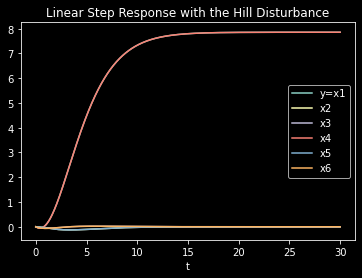

In [ ]:
# Goal: Plot the linear step response with step disturbance
#our "f" function (defined by xdot = f(x,r))
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  xp = np.array([np.array(x[:3])]).transpose() 
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = step_fn(t)
  d = 1  

  #compute f(x,t) from linearized state space
  u = (r-K@xo+d).item()
  y = (Cn@xp).item()
  yhat = (Cn@xo).item()
  xpdot = (An@xp+Bn*u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Step Response with the Hill Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"])
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.792792792792792 
 Overshoot =  5.289904958223614e-05 
 Settling response =  7.8560332408324145 
 Max response = 7.856448817524341


Text(0.5, 0, 't')

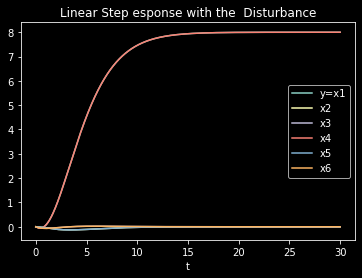

In [ ]:
# Goal: Plot the linear step response with impulse disturbance
#our "f" function (defined by xdot = f(x,r))
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  xp = np.array([np.array(x[:3])]).transpose() 
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = step_fn(t)
  d = approx_impulse(t) / -56.5

  #compute f(x,t) from linearized state space
  u = (r-K@xo+d).item()
  y = (Cn@xp).item()
  yhat = (Cn@xo).item()
  xpdot = (An@xp+Bn*u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Step esponse with the  Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"])
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.792792792792792 
 Overshoot =  5.3365950575476746e-05 
 Settling response =  7.997579283303169 
 Max response = 7.998006081723926


Text(0.5, 0, 't')

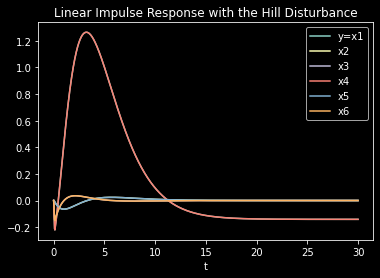

In [ ]:
# Goal: Plot the linear impulse response with step disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = approx_impulse(t)
  d = step_fn(t) / -56.5

  # compute output from controller
  u = (r-K@xo+d).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) nonlinear functions
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]
 
# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial states
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Impulse Response with the Hill Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.2648254227940314


Text(0.5, 0, 't')

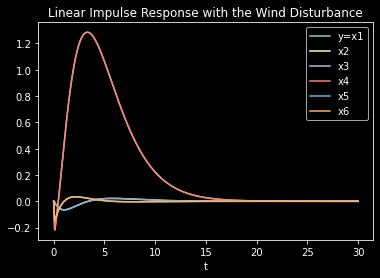

In [ ]:
# Goal: Plot the linear impulse response with impulse disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = approx_impulse(t)
  d = approx_impulse(t) / -56.5

  #compute output from controller
  u = (r-K@xo+d).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear function
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]
 
# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial states
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Impulse Response with the Wind Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.2849553284733315


Text(0.5, 0, 't')

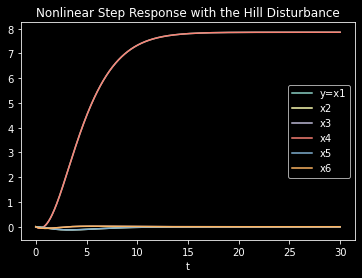

In [ ]:
# Part (b)
# Goal: Plot the nonlinear step response with the step disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 
  dis = step_fn(t) / -56.5

  #compute output from controller
  u = (r-K@xo+dis).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear functions
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot the response
t = np.linspace(0,30,1000)
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Nonlinear Step Response with the Hill Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.732732732732732 
 Overshoot =  4.7100976622997804e-05 
 Settling response =  7.856084926621621 
 Max response = 7.856454955894098


Text(0.5, 0, 't')

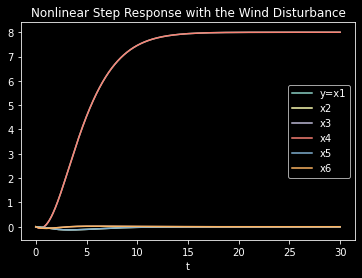

In [ ]:
# Part (b)
# Goal: Plot the nonlinear step response with the impulse disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r 
  r = step_fn(t) 
  dis = approx_impulse(t) / -56.5

  #compute output from controller
  u = (r-K@xo+dis).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear functions
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]

# plot the response
t = np.linspace(0,30,1000)
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial conditions
plt.figure()
plt.plot(t,x_of_t)
plt.title('Nonlinear Step Response with the Wind Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Settling time = ", find_Ts(x_of_t[:,0], t, 1), "\n Overshoot = ", find_OS(x_of_t[:,0]), "\n Settling response = ", find_avg(x_of_t[:,0]), "\n Max response =", max(x_of_t[:,0]))

 Settling time =  12.762762762762762 
 Overshoot =  4.730828285046221e-05 
 Settling response =  7.997634007734026 
 Max response = 7.998012362065799


Text(0.5, 0, 't')

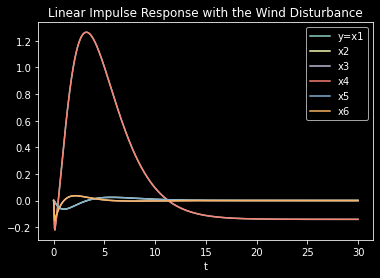

In [ ]:
# Goal: Plot the nonlinear impulse response with the step disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = approx_impulse(t)
  dis = step_fn(t) / -56.5

  #compute output from controller
  u = (r-K@xo+dis).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear function
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]
 
# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial states
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Impulse Response with the Wind Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.2648254227940314


Text(0.5, 0, 't')

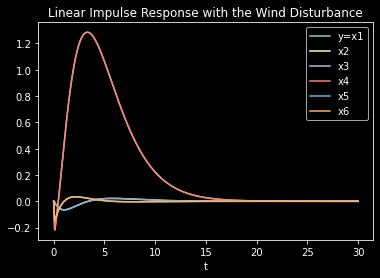

In [ ]:
# Goal: Plot the nonlinear impulse response with the impulse disturbance

#make our nonlinear "f(x1,x2,x3,u)" into a function that evaluates to numbers
f = Matrix([[P_ddotn],[thetadot],[T_ddotn]])
fp = lambdify([pdot, theta, thetadot, tau],f,"numpy")

#our "f" function ( defined by xdot = f(x,r)  )
def ffn(x,t):
  #extract plant and observer dynamics and make it a column 
  pdot,theta,thetadot = x[:3]
  xo = np.array([np.array(x[3:])]).transpose()
 
  #compute r and d
  r = approx_impulse(t)
  dis = approx_impulse(t) / -56.5

  #compute output from controller
  u = (r-K@xo+dis).item()
  y = pdot
  yhat = (Cn@xo).item()
   
  #compute fp(x,u) from nonlinear function
  xpdot = fp(pdot,theta,thetadot,u).flatten()
  xodot = (An@xo+Bn*u+L*(y-yhat)).flatten()
  
  #return derivatives. 
  return [xpdot[0],xpdot[1],xpdot[2],xodot[0],xodot[1],xodot[2]]
 
# plot response
t = np.linspace(0,30,1000) 
x_of_t = spi.odeint(ffn,[0,0,0,0,0,0],t) # initial states
plt.figure()
plt.plot(t,x_of_t)
plt.title('Linear Impulse Response with the Wind Disturbance')
plt.legend(["y=x1","x2","x3","x4","x5","x6"],)
plt.xlabel("t")

In [ ]:
print(" Max response =", max(x_of_t[:,0]))

 Max response = 1.2849553284733315


In [ ]:
column1 = Matrix([Aeq,LC])
column2 = Matrix([-Beq*K,Ahat-LC])
Afsfb = MatrixFromColumns([column1[:,0],column1[:,1],column1[:,2],column2[:,0],column2[:,1],column2[:,2]])
Bfsfb = Matrix([Beq,Beq])
Cfsfb = Matrix([[1,0,0,0,0,0]])
Dfsfb = Matrix([[0]])

Afsfb = np.array(Afsfb).astype(np.float64)
Bfsfb = np.array(Bfsfb).astype(np.float64)
Cfsfb = np.array(Cfsfb).astype(np.float64)
Dfsfb = np.array(Dfsfb).astype(np.float64)

Afsfb, Bfsfb, Cfsfb, Dfsfb

(array([[-1.27272727e-02,  2.67545455e+00, -2.42424242e-03,
          4.48373645e-02, -1.40907400e+01, -2.73685201e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-8.48484848e-03,  8.32363636e+00, -7.54208754e-03,
          2.98915763e-02, -9.39382665e+00, -1.82456800e+00],
        [ 1.19797306e+01,  0.00000000e+00,  0.00000000e+00,
         -1.19476205e+01, -1.14152854e+01, -2.73927625e+00],
        [ 2.06985399e+01,  0.00000000e+00,  0.00000000e+00,
         -2.06985399e+01,  0.00000000e+00,  1.00000000e+00],
        [ 5.97274800e+01,  0.00000000e+00,  0.00000000e+00,
         -5.97060733e+01, -1.07019028e+00, -1.83211009e+00]]),
 array([[0.00454545],
        [0.        ],
        [0.0030303 ],
        [0.00454545],
        [0.        ],
        [0.0030303 ]]),
 array([[1., 0., 0., 0., 0., 0.]]),
 array([[0.]]))

In [ ]:
Tfsfb = ctrl.ss2tf(Afsfb,Bfsfb,Cfsfb,Dfsfb)
Tfsfb


0.004545 s^5 + 0.05457 s^4 + 0.1842 s^3 - 0.08273 s^2 - 1.396 s - 1.784
-----------------------------------------------------------------------
  s^6 + 13.8 s^5 + 69.67 s^4 + 157.7 s^3 + 160.8 s^2 + 74.07 s + 12.6

## Task 8: Discretization (optional)

Derive a discrete model of one of your controlled systems (either the root locus version, the full state feedback version, or the full state feedback with observer version).  Plot the magnitude of the eigenvalues of the closed loop system versus the sampling period. Determine maximum sampling period you can use with your controller that keeps the system stable.

## Task 9: Realism (optional)

Our model is not perfect.  For one thing we're using an average child rider for parameters in our model.  How do any or all of your systems perform with larger or smaller riders?

What other things are unrealistic or uncertain?  How does this effect the system?  What if there's a delay in your speed measurement?

Answer as much of the above as you wish and include any other analysis you think is pertenant.

#DOCUMENT CHANGE LOG:

Incase any errors are caught and corrected this section will contain the change log

5/20 2am: version - "draft": Released draft assignment.  
5/20 8pm: 1.0 - fixed into.  Clarified sensitivity task.